<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [11]:
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cv2
try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        print((1))
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    print('Not IPYTHON')
    pass

import caiman as cm
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf.utilities import detrend_df_f
from caiman.components_evaluation import estimate_components_quality_auto
import bokeh.plotting as bpl
bpl.output_notebook()

1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

### Setup some parameters

In [12]:
# dataset dependent parameters
fname = [#A_10 
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T6_G.tiff',
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T31_G.tiff',
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T56_G.tiff',
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T81_G.tiff',

         #B_10
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T7_G.tiff',
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T32_G.tiff',
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T57_G.tiff',
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T82_G.tiff',
         
        #A+B_10
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T20_G.tiff', 
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T45_G.tiff',
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T70_G.tiff',
        '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T95_G.tiff',
]  

# filename to be processed
fr = 4                             # imaging rate in frames per second
decay_time = 0.4                    # length of a typical transient in seconds

# motion correction parameters
niter_rig = 1               # number of iterations for rigid motion correction
max_shifts = (6, 6)         # maximum allow rigid shift
splits_rig = 2             # for parallelization split the movies in  num_splits chuncks across time
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
splits_els = 2             # for parallelization split the movies in  num_splits chuncks across time
upsample_factor_grid = 4    # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3     # maximum deviation allowed for patch with respect to rigid shifts

# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thresh = 0.8          # merging threshold, max correlation allowed
rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 4                       # number of components per patch
gSig = [4, 4]               # expected half size of neurons
init_method = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
is_dendrites = False        # flag for analyzing dendritic data
alpha_snmf = None           # sparsity penalty for dendritic data analysis through sparse NMF

# parameters for component evaluation
min_SNR = 2.5               # signal to noise ratio for accepting a component
rval_thr = 0.8              # space correlation threshold for accepting a component
cnn_thr = 0.8               # threshold for CNN based classifier

Download the dataset if not already present

In [13]:
if fname[0] in ['Sue_2x_3000_40_-46.tif','demoMovie.tif']:
    fname = [download_demo(fname[0])]

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel.

In [14]:
m_orig = cm.load(fname[:12])
downsample_ratio = 0.2
offset_mov = -np.min(m_orig[:100])  # make the dataset mostly non-negative
m_orig.resize(1, 1, downsample_ratio).play(
gain=10, offset=offset_mov, fr=4, magnification=2)

100%|██████████| 12/12 [00:01<00:00,  8.98it/s]


reshaping along z


##### Setup a cluster

In [16]:
#%% start a cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

Exception: A cluster is already runnning. Terminate with dview.terminate() if you want to restart.

## Motion Correction
First we create a motion correction object with the parameters specified. Note that the file is not loaded in memory

In [17]:
# first we create a motion correction object with the parameters specified
min_mov = min(cm.load(fname[0], subindices=slice(200)).min(),0) 
        # this will be subtracted from the movie to make it non-negative 

mc = MotionCorrect(fname[:12], min_mov,
                   dview=dview, max_shifts=max_shifts, niter_rig=niter_rig,
                   splits_rig=splits_rig, 
                   strides= strides, overlaps= overlaps, splits_els=splits_els,
                   upsample_factor_grid=upsample_factor_grid,
                   max_deviation_rigid=max_deviation_rigid, 
                   shifts_opencv = True, nonneg_movie = True)
# note that the file is not loaded in memory

Now perform motion correction. From the movie above we see that the dateset exhibits non-uniform motion. We will perform piecewise rigid motion correction using the NoRMCorre algorithm.

In [19]:
%%capture
#%% Run piecewise-rigid motion correction using NoRMCorre
mc.motion_correct_pwrigid(save_movie=True)
m_els = cm.load(mc.fname_tot_els)
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)  
    # maximum shift to be used for trimming against NaNs

Inspect the results by comparing the original movie. A more detailed presentation of the motion correction method can be found in the [demo motion correction](./demo_motion_correction.ipynb) notebook.

In [20]:
#%% compare with original movie
cm.concatenate([m_orig.resize(1, 1, downsample_ratio)+offset_mov,
                m_els.resize(1, 1, downsample_ratio)], 
               axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit

reshaping along z
reshaping along z


## Memory mapping 

The cell below memory maps the file in order `C` and then loads the new memory mapped file.

In [21]:
#%% MEMORY MAPPING
# memory map the file in order 'C'
fnames = mc.fname_tot_els   # name of the pw-rigidly corrected file.
border_to_0 = bord_px_els     # number of pixels to exclude
fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C',
                           border_to_0 = bord_px_els) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

RECOMPUTING EACH FILE MEMORY MAP
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T6_G._els__d1_301_d2_300_d3_1_order_F_frames_109_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T31_G._els__d1_301_d2_300_d3_1_order_F_frames_109_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T56_G._els__d1_301_d2_300_d3_1_order_F_frames_109_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T81_G._els__d1_301_d2_300_d3_1_order_F_frames_109_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T7_G._els__d1_301_d2_300_d3_1_order_F_frames_109_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071

done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0005_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0006_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0007_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/m

done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0005_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0006_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0007_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/m

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0008_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0009_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0010_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0011_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(21672, 22575)
done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_10

(28896, 29799)
done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0005_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0006_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0007_d1_301_d2_300_d3_1_order_C_frames_10

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0009_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0010_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0011_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(36120, 37023)
done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_10

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0005_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0006_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0007_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0008_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Deskt

done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0005_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0006_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0007_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/m

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0011_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(56889, 57792)
done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0005_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0006_d1_301_d2_300_d3_1_order_C_frames_10

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0006_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0007_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0008_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0009_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0010_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0011_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(64113, 65016)
done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_10

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0010_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0011_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(70434, 71337)
done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0005_d1_301_d2_300_d3_1_order_C_frames_10

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0005_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0006_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0007_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0008_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0009_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Deskt

/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0009_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0010_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0011_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(82173, 83076)
done
(903, 1307)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0002_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0003_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0004_d1_301_d2_300_d3_1_order_C_frames_10

Now restart the cluster to clean up the memory

In [22]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

(1307, 31, 31)
(1307, 31, 31)
using 1 processes
using 1 processes
using 225 pixels per process
using 225 pixels per process
(1307, 31, 31)
(1307, 31, 31)
using 5000 block_size
(1307, 31, 31)
using 5000 block_size
using 1 processes
preprocessing ...
using 1 processes
(1307, 31, 31)
checking if missing data
preprocessing ...
using 1 processes
using 225 pixels per process
checking if missing data
using 1 processes
using 5000 block_size
preprocessing ...
using 225 pixels per process
checking if missing data
using 225 pixels per process
using 225 pixels per process
using 5000 block_size
using 5000 block_size
using 5000 block_size
preprocessing ...
preprocessing ...
preprocessing ...
checking if missing data
checking if missing data
checking if missing data
initializing ...
Noise Normalization
initializing ...
Spatial Downsampling 2-photon
initializing ...
reshaping along x and y
Noise Normalization
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(653, 15)
Spatial D

preprocessing ...
checking if missing data
(1307, 31, 31)
(Hals) Refining Components...
(1307, 31, 31)
using 1 processes
using 1 processes
using 225 pixels per process
using 5000 block_size
using 225 pixels per process
preprocessing ...
using 5000 block_size
checking if missing data
preprocessing ...
checking if missing data
False
(1307, 31, 31)
using 1 processes
using 225 pixels per process
using 5000 block_size
preprocessing ...
(Hals) Refining Components...
checking if missing data
False
(1307, 31, 31)
using 1 processes
using 225 pixels per process
using 5000 block_size
preprocessing ...
initializing ...
checking if missing data
initializing ...
Noise Normalization
(653, 15)
reshaping along x and y
Spatial Downsampling 2-photon
reshaping along z
Noise Normalization
***** OPENCV!!!!
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
reshaping along x and y
Roi Extraction...
reshaping along x and y
Greedy initialization of spatial and temp

preprocessing ...
checking if missing data
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(653, 15)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
initializing ...
Noise Normalization
initializing ...
Noise Normalization
initializing ...
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
Noise Normalization
initializing ...
reshaping along x and y
Spatial Downsampling 2-photon
reshaping along x and y
reshaping along x and y
(653, 15)
Noise Normalization
(653, 15)
(653, 15)
Spatial Downsampling 2-photon
reshaping along z
reshaping along z
reshaping along x and y
***** OPENCV!!!!
***** OPENCV!!!!
reshaping along z
Roi Extraction...
(653, 15)
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Roi Extraction...
Greedy initializati

reshaping along z
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
initializing ...
Noise Normalization
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
reshaping along x and y
reshaping along x and y
(653, 15)
(653, 15)
reshaping along z
reshaping along z
***** OPENCV!!!!
Roi Extraction...
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
initializing ...
Noise Normalization
False
Spatial Downsampling 2-photon
reshaping along x and y
initializing ...
(653, 15)
Noise Normalization
reshaping along z
(1307, 31, 31)
using 1 processes
using 225 pixels per 

reshaping along x and y
reshaping along z
***** OPENCV!!!!
reshaping along x and y
(653, 15)
Roi Extraction...
reshaping along z
(653, 15)
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
***** OPENCV!!!!
initializing ...
Noise Normalization
reshaping along z
Roi Extraction...
Spatial Downsampling 2-photon
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along x and y
***** OPENCV!!!!
USING ROLLING SUM FOR INITIALIZATION....
(653, 15)
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along z
USING ROLLING SUM FOR INITIALIZATION....
***** OPENCV!!!!
Roi Extraction...
USING ROLLING SUM FOR INITIALIZATION....
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
initializing ...
Noise Normalization
USING ROLLING SUM FOR INITIALIZATION....
Spatial Downsampling 2-photon
reshaping along x and y
(653

(653, 15)
initializing ...
reshaping along z
Noise Normalization
initializing ...
***** OPENCV!!!!
Roi Extraction...
Noise Normalization
Spatial Downsampling 2-photon
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(Hals) Refining Components...
reshaping along x and y
(653, 15)
Spatial Downsampling 2-photon
reshaping along z
***** OPENCV!!!!
reshaping along x and y
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
False
USING ROLLING SUM FOR INITIALIZATION....
(1307, 31, 31)
(653, 15)
using 1 processes
USING ROLLING SUM FOR INITIALIZATION....
using 225 pixels per process
reshaping along z
using 5000 block_size
***** OPENCV!!!!
preprocessing ...
checking if missing data
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
initializing ...
initializing ...
(Hals) Refining Components...
Noise Nor

Spatial Downsampling 2-photon
reshaping along x and y
(653, 15)
reshaping along z
initializing ...
Roi Extraction...
***** OPENCV!!!!
USING ROLLING SUM FOR INITIALIZATION....
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Roi Extraction...
reshaping along z
Noise Normalization
Spatial Downsampling 2-photon
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along x and y
USING ROLLING SUM FOR INITIALIZATION....
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(653, 15)
USING ROLLING SUM FOR INITIALIZATION....
reshaping along z
***** OPENCV!!!!
initializing ...
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Noise Normalization
USING ROLLING SUM FOR INITIALIZATION....
Spatial Downsampling 2-photon
reshaping along x and y
USING ROLLING SUM FOR INITIALIZATION....
(6

(653, 15)
Spatial Downsampling 2-photon
USING ROLLING SUM FOR INITIALIZATION....
reshaping along z
reshaping along x and y
***** OPENCV!!!!
Roi Extraction...
(653, 15)
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along z
initializing ...
***** OPENCV!!!!
USING ROLLING SUM FOR INITIALIZATION....
Roi Extraction...
Noise Normalization
Spatial Downsampling 2-photon
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along x and y
(653, 15)
reshaping along z
USING ROLLING SUM FOR INITIALIZATION....
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
(Hals) Refining Components...
initializing ...
Noise Normalization
False
Spatial Downsampling 2-photon
reshaping along x and y
False
(653, 15)
reshaping along z
(Hals) Refining Components...
***** OPENC

49999
54999
59999
69999
64999
74999
79999
89999
84999
90299
4999
9999
14999
19999
24999
29999
34999
44999
39999
49999
54999
59999
69999
64999
74999
79999
84999
89999
90299


## Run CNMF on patches in parallel

<p> <img src="../../docs/img/cnmf1.png" /> </p>

- The FOV is split is different overlapping patches that are subsequently processed in parallel by the CNMF algorithm.
- The results from all the patches are merged with special attention to idendtified components on the border.
- The results are then refined by additional CNMF iterations.

In [23]:
%%capture
#%% RUN CNMF ON PATCHES

# First extract spatial and temporal components on patches and combine them
# for this step deconvolution is turned off (p=0)
t1 = time.time()

cnm = cnmf.CNMF(n_processes=1, k=K, gSig=gSig, merge_thresh= merge_thresh, 
                p = 0,  dview=dview, rf=rf, stride=stride_cnmf, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, 
                only_init_patch = False, gnb = gnb, border_pix = bord_px_els) 
cnm = cnm.fit(images)

plot contours of identified components against correlation image

/home/murthyhacker/CaImAn/caiman/summary_images.py:206: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
/home/murthyhacker/CaImAn/caiman/utils/visualization.py:953: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


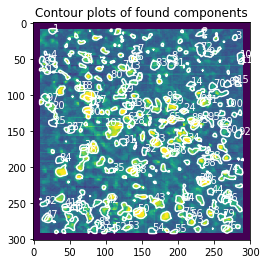

In [24]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
plt.figure(); crd = plot_contours(cnm.A, Cn, thr=0.9)
plt.title('Contour plots of found components')

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>

In [25]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, SNR_comp, r_values, cnn_preds = \
    estimate_components_quality_auto(images, cnm.A, cnm.C, cnm.b, cnm.f, 
                                     cnm.YrA, fr, decay_time, gSig, dims, 
                                     dview = dview, min_SNR=min_SNR, 
                                     r_values_min = rval_thr, use_cnn = False, 
                                     thresh_cnn_lowest = cnn_thr)

EVALUATING IN PARALLEL... NOT RETURNING ERFCs


Plot contours of selected and rejected components

/home/murthyhacker/CaImAn/caiman/utils/visualization.py:953: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


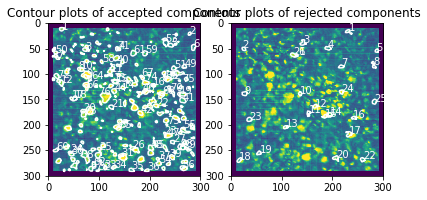

In [26]:
#%% PLOT COMPONENTS

plt.figure();
plt.subplot(121); crd_good = cm.utils.visualization.plot_contours(cnm.A[:,idx_components], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of accepted components')
plt.subplot(122); crd_bad = cm.utils.visualization.plot_contours(cnm.A[:,idx_components_bad], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of rejected components')

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [27]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons =Cn,
                denoised_color = 'red');

In [28]:
# rejected components
if len(idx_components_bad) > 0:
    nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                    cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons =Cn,
                    denoised_color = 'red');
else:
    print("No components were rejected.")

## Re-run (seeded) CNMF  on the full Field of View  

In [29]:
%%capture
#%% RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution 
A_in, C_in, b_in, f_in = cnm.A[:,idx_components], cnm.C[idx_components], cnm.b, cnm.f
cnm2 = cnmf.CNMF(n_processes=1, k=A_in.shape[-1], gSig=gSig, p=p, dview=dview,
                merge_thresh=merge_thresh,  Ain=A_in, Cin=C_in, b_in = b_in,
                f_in=f_in, rf = None, stride = None, gnb = gnb, 
                method_deconvolution='oasis', check_nan = True)

cnm2 = cnm2.fit(images)

### Extract DF/F values

In [30]:
#%% Extract DF/F values

F_dff = detrend_df_f(cnm2.A, cnm2.b, cnm2.C, cnm2.f, YrA = cnm2.YrA, 
                      quantileMin=8, frames_window=250)

## Display final results

In [31]:
discard_traces_fluo=nb_view_patches(Yr,cnm2.A, cnm2.C, cnm2.b, cnm2.f,
                                    dims[0], dims[1], thr = 0.8, image_neurons=Cn,
                                    denoised_color='red')
print('you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10')

you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10


<h1> closing, saving, and creating denoised version </h1>

In [32]:
save_results = False
if save_results:
    np.savez(os.path.join(os.path.split(fname_new)[0], 
                          os.path.split(fname_new)[1][:-4] + 'results_analysis.npz'),
             Cn=Cn, A=cnm2.A.todense(), C=cnm2.C,
             b=cnm2.b, f=cnm2.f, YrA=cnm2.YrA, sn=sn, d1=d1, d2=d2,
             idx_components=idx_components, idx_components_bad=idx_components_bad)

## stop cluster and clean up LOG files

In [33]:
#%% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

We can inspect the denoised results by reconstructing the movie and playing alongside the original

In [34]:
#%% reconstruct denoised movie
denoised = cm.movie(cnm2.A.dot(cnm2.C) + \
                    cnm2.b.dot(cnm2.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])

In [35]:
#%% play along side original data
cm.concatenate([m_els.resize(1, 1, downsample_ratio),
                denoised.resize(1, 1, downsample_ratio)], 
                axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit

reshaping along z
reshaping along z
